### Executive Summary:

In this exercise Dijkstra's algorithm is examined by finding the fastest way from NYC to Los Angeles through a weighted connections graph showing the hours (or weights) it would take going from city to city. Basically Dijsktra's algorithm works by finding the "cheapest" node (city), or the node that we can get to in the least amount of time, update the the costs (hours) of the neighbors of the node (city), and repeat until this is done for every node (city) in the graph [1]. Then the final path is calculated, where the fastest path is found through the lowest costs (hours) of neighboring nodes (cities). The algorithm in this exercise is compared with the breadth-first search algorithm, which instead of finding the fastest path, it finds the shortest. The breadth-first search algorithm will find the shortest path between two nodes that are connected to other nodes by the unweighted edges. The algorithm will first determine if there is a path leading from one node to the other, and it will then find the shortest path by searching the entire network of connections finding the shortest path connections between the two nodes. Thus, in this exercise, the path and the total hours from start to destination is evaluated. Execution times are also recorded. Further explanation on how the algorithms work, and their relationship to Big O notation is discussed.

Based on the results of this exercise, it is recommended that the Dijkstra's algorithm is used for cases where a weighted connections graph is necessary for a fastest path problem. It is useful to the data engineer to know how the algorithm works and how it is implemented, as it is an effective means to solve complex problems involving weighted edges, where other search algorithms cannot be easily applied.   

### Import Libraries:

In [1]:
#For math
import numpy as np
#For data
import pandas as pd
#For Plotting
import matplotlib.pyplot as plt
# Timer
from timeit import default_timer as timer
#Deque FIFO
from collections import deque, namedtuple

### Class and Function Definitions:

#### Dijkstra's Algorithm:
 - Dijkstra's algorithm will find the fastest path between two nodes that are connected to other nodes by weighted edges.
 - Dijsktra's algortihm has four steps [1]:
  - Find the cheapest node that has the smallest weight or the lowest cost from the starting node and its neighbors.
  - Check whether there is a cheaper path to the neighbors of this node, and if so, update their costs.
  - Repeat until this done for every node in the graph.
  - Calculate the final path.  
 - Dijkstra's algorithm only works with directed acyclic graphs (DAG). A DAG is a finite directed graph with no directed cycles.
 - Dijkstra's algorithm basically works by:
  - Initially the algorithm is set up where the current costs to neighboring nodes are tracked, and all other costs are set to infinity as they have not been reached from the start yet. The cost for the final node is also set to infinity. 
  - Neighboring nodes are usually tracked by a parent node. As the cheapest paths are found through each node's neighbors, costs are updated and is associated with each parent.
  - As updating costs of neighboring nodes gets repeated the final cost to the last node gets calculated through each parent leading to the starting node. 
  - The algorithm finally determines the fastest path by calculating the lowest costs leading to the final node. 
 - In terms of Big O notation, at its worst case, assuming that the graph is using a self-balancing binary search tree, it is written as **O(|E|+|V|)log|V|)**. |V| is for the number of vertices, and |E| is for the number of edges, or connections. When an entire network is searched, each edge is followed, and so the run time is at the least, **O(number of edges)**. There is also a queue for every node that is to be searched, and adding one node to the queue takes **O(1)** constant time. Doing this for every node will take **(O number of nodes)** total. **log |V|** is the time that it takes to go through neighboring vertices. Therefore, total run time is **O(|E|+|V|)log|V|)** in the case of a self-balancing binary search tree [2].
 - It is important to note that Dijkstra's algorithm cannot work with weighted edges that are negative. In this case, the Bellman-Ford algorithm can be used. 

In [11]:
# Class definition for Dijkstra's algorithm
# infinity is used as a default distance to nodes.
inf = float('inf')
Edge = namedtuple('Edge', 'start, end, cost')


def make_edge(start, end, cost=1):
      return Edge(start, end, cost)


class Graph:
    def __init__(self, edges): #initialize the data
        # checks that the data is right
        wrong_edges = [i for i in edges if len(i) not in [2, 3]]
        if wrong_edges:
            raise ValueError('Wrong edges data: {}'.format(wrong_edges))

        self.edges = [make_edge(*edge) for edge in edges]

    @property
    def vertices(self):
        return set( #set makes the elements unique
            sum(
                ([edge.start, edge.end] for edge in self.edges), [] # turns ([1,2], [3,4] into [1, 2, 3, 4])
            )
        )

    # code below adds adding and removing functionality
    def get_node_pairs(self, n1, n2, both_ends=True):
        if both_ends:
            node_pairs = [[n1, n2], [n2, n1]]
        else:
            node_pairs = [[n1, n2]]
        return node_pairs

    def remove_edge(self, n1, n2, both_ends=True):
        node_pairs = self.get_node_pairs(n1, n2, both_ends)
        edges = self.edges[:]
        for edge in edges:
            if [edge.start, edge.end] in node_pairs:
                self.edges.remove(edge)

    def add_edge(self, n1, n2, cost=1, both_ends=True):
        node_pairs = self.get_node_pairs(n1, n2, both_ends)
        for edge in self.edges:
            if [edge.start, edge.end] in node_pairs:
                return ValueError('Edge {} {} already exists'.format(n1, n2))

        self.edges.append(Edge(start=n1, end=n2, cost=cost))
        if both_ends:
            self.edges.append(Edge(start=n2, end=n1, cost=cost))

    #find the neighbours of each node
    @property
    def neighbours(self):
        neighbours = {vertex: set() for vertex in self.vertices}
        for edge in self.edges:
            neighbours[edge.start].add((edge.end, edge.cost))

        return neighbours

    # the code below runs the algorithm based on the properties set above
    def dijkstra(self, source, dest):
        assert source in self.vertices, 'Such source node doesn\'t exist'
        #1. marks all nodes unvistited and stores them
        #2. sets the distance to zero for initial node
        # and infinity for the other nodes
        distances = {vertex: inf for vertex in self.vertices}
        previous_vertices = {
            vertex: None for vertex in self.vertices
        }
        distances[source] = 0
        vertices = self.vertices.copy()

        while vertices:
            #3. selects the unvisited node with smallest distance
            #making it the current node
            current_vertex = min(
                vertices, key=lambda vertex: distances[vertex])
            vertices.remove(current_vertex)
            # 6. stops it if the smallest distance among the unvisited nodes is infinity
            if distances[current_vertex] == inf:
                break
            # 4. finds the unvisited neighbors for the current node and calculates
            # their distances or cost through the current node
            for neighbour, cost in self.neighbours[current_vertex]:
                alternative_route = distances[current_vertex] + cost
                # compares the newly calculated distance to the assigned 
                #and saves the smaller one
                if alternative_route < distances[neighbour]:
                    distances[neighbour] = alternative_route
                    previous_vertices[neighbour] = current_vertex
            
        # 5. mark the current node as visited and remove it
        # from the unvisited set
        path, current_vertex = deque(), dest
        while previous_vertices[current_vertex] is not None:
            path.appendleft(current_vertex)
            current_vertex = previous_vertices[current_vertex]
        if path:
            path.appendleft(current_vertex)
        # return path and distances associated with costs, fastest time is destination node 
        return np.array([np.array(path), distances]) 

#### Breadth-first Search:
 - A breadth-first search algorithm helps to answer two questions [1]: 
  - 1.) Is there a path from node A to node B? 
  - 2.) What is the shortest path between node A to node B?  
 - Therefore, a breadth-first search algorithm will find the shortest path between two nodes that are connected to other nodes by edges.
 - The algorithm will search the entire network of connections until it finds the shortest path to the node that is being searched.
 - Breadth-first search works by radiating out from the starting point. It will check first degree connections before second degree connections, third degree connections before second degree connections, and so on.
 - Additionally, the algorithm searches nodes in the order that they are added. In other words, it uses a data structure called a *queue*, which works by using a FIFO (First In, First Out) method; the first item that is added to the queue is the first item that is taken off the queue [1]. It uses this data structure so that first degree connections are searched before second degree connections.    
 - The algorithm is thus implemented by first adding all first degree connections to a queue, which will then "pop" a node off the queue and see if it is the specific node that is being searched. If it is not the node, it will then add all neighboring connections to the queue, and it will continue the process until the node is found or the queue is empty.
 - In terms of Big O notation, it is written as **O(V+E)**. V is for the number of vertices, and E is for the number of edges, or connections. When an entire network is searched, each edge is followed, and so the run time is at the least, **O(number of edges)**. There is also a queue for every node that is to be searched, and adding one node to the queue takes **O(1)** constant time. Doing this for every node will take **(O number of nodes)** total. Therefore, total run time is **O(V+E)** [1].
 - In contrast to Dijkstra's algorithm, breadth-first search works on unweighted edges, finding the shortest path through the least amount of segments.  

In [8]:
# Function for Breadth-first search
def bfs_shortest_path(graph, start, goal):
    # keep track of explored nodes
    explored = []
    # keep track of all the paths to be checked
    queue = [[start]]
 
    # return path if start is goal
    if start == goal:
        return [start, goal]
 
    # keeps looping until all possible paths have been checked
    while queue:
        # pop the first path from the queue
        path = queue.pop(0)
        # get the last node from the path
        node = path[-1]
        if node not in explored:
            neighbours = graph[node]
            # go through all neighbour nodes, construct a new path and
            # push it into the queue
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                # return path if neighbour is goal
                if neighbour == goal:
                    return np.array(new_path)
 
            # mark node as explored
            explored.append(node)
 
    # in case there's no path between the 2 nodes
    return 'Path does not exist'

### Graphs:
 - As the two functions used for each algorithm are different, they require the creation of two different graphs.

#### Graph for Djikstra's Algorithm:

In [12]:
# Graph for Djikstra's algorithm
graph_dj = Graph([('NYC', 'DC', 2), ('NYC', 'Indianapolis', 11), ('NYC', 'Pittsburgh', 7), ('DC', 'Atlanta', 2), 
                  ('Indianapolis', 'Kansas City', 8), ('Pittsburg', 'Cincinnati', 6), ('Atlanta', 'New Orleans', 2), 
                  ('New Orleans', 'Dallas', 2), ('Dallas', 'Albuquerque', 2), ('Albuquerque', 'Phoenix', 2), 
                  ('Phoenix', 'Las Vegas', 2), ('Phoenix', 'San Diego', 5), ('Las Vegas', 'Los Angeles', 5),
                  ('Las Vegas', 'San Diego', 2), ('San Diego', 'Los Angeles', 2), ('Kansas City', 'Denver', 7), 
                  ('Denver', 'Salt Lake City', 6), ('Salt Lake City', 'Las Vegas', 9), ('Cincinatti', 'St. Louis', 8),
                  ('St. Louis', 'Oklahoma City', 7), ('Oklahoma City', 'Albuquerque', 9)])  

#### Graph for Breadth-first Search:

In [9]:
# Graph for BFS
graph_bfs = {('NYC', 0):[('DC', 2), ('Indianapolis', 11), ('Pittsburgh', 7)],
            ('DC', 2):[('Atlanta', 2)], ('Atlanta', 2):[('New Orleans', 2)], ('New Orleans', 2):[('Dallas', 2)], 
            ('Dallas', 2):[('Albuquerque', 2)], ('Indianapolis', 11):[('Kansas City', 8)], 
            ('Kansas City', 8): [('Denver', 7)], ('Denver', 7):[('Salt Lake City', 6)], 
            ('Salt Lake City', 6):[('Las Vegas', 9)], ('Pittsburgh', 7):[('Cinncinati', 6)], 
            ('Cinncinati', 6): [('St. Louis', 8)], ('St. Louis', 8):[('Oklahoma City', 7)], 
            ('Oklahoma City', 7): [('Albuquerque', 9)], ('Albuquerque', 2): [('Phoenix', 2)], 
            ('Albuquerque', 9): [('Phoenix', 2)], ('Phoenix', 2):[('Las Vegas', 2), ('San Diego', 5)],
            ('Las Vegas', 2): [('San Diego', 2), ('Los Angeles', 5)],
            ('Las Vegas', 9): [('San Diego', 2), ('Los Angeles', 5)], ('San Diego', 2): [('Los Angeles', 2)],
            ('Los Angeles', 5): [('Los Angeles', 0)], ('Los Angeles', 2): [('Los Angeles', 0)]}

### Best Routes with Algorithms:

#### Breadth-first Search:

In [19]:
# BFS from NYC to LA showing path, total hours, and execution time
start = timer()
path = bfs_shortest_path(graph_bfs, ('NYC',0), ('Los Angeles', 0))
end = timer()
exec_time_bfs = (end - start)*1000
shortest_path = path[0:-1]
shortest_path = shortest_path[:,0][:]
total_hours_bfs = sum(path[:, 1].astype('int'))
print('Route to Los Angeles: \n', shortest_path, '\n Total Hours:', total_hours_bfs, 
      '\n Execution Time(ms):', exec_time_bfs)

Route to Los Angeles: 
 ['NYC' 'Indianapolis' 'Kansas City' 'Denver' 'Salt Lake City' 'Las Vegas'
 'Los Angeles'] 
 Total Hours: 46 
 Execution Time(ms): 0.11839999933727086


#### Dijsktra's Algorthim:

In [28]:
# Dijkstra's algortihm from NYC to LA showing path, total hours, and execution time
start = timer()
shortest_time = graph_dj.dijkstra('NYC', 'Los Angeles')
total_hours_dij = shortest_time[1]['Los Angeles']
end = timer()
exec_time_dij = (end - start)*1000
print('Route to Los Angeles: \n', shortest_time[0], '\n Total Hours:', total_hours_dij, 
      '\n Execution Time(ms):', exec_time_dij)

Route to Los Angeles: 
 ['NYC' 'DC' 'Atlanta' 'New Orleans' 'Dallas' 'Albuquerque' 'Phoenix'
 'Las Vegas' 'San Diego' 'Los Angeles'] 
 Total Hours: 18 
 Execution Time(ms): 0.6484999994427199


### Comparison Table and Graph:

#### Table:
 - It is clear that both algorithms accomplished the tasks that they were meant for. Breadth-first search found the shortest path, which was to go through 5 different cities, whereas Dijsktra's algorithm found the best route to be 8 different cities. 
 - However, the total hours to get from start to destination are starkly different. Although breadth-first search found the shortest path, the total hours to get to the destination using the shortest path is 46 hours. On the other hand, Dijkstra's algorithm determined that with 8 different cities, it would take 8 hours, by finding the fastest path. 
 - It is evident that the execution times are significantly different. Yet it is a better trade-off finding the fastest path to get from node A to node B through a network of weighted edges at the cost of a longer execution time, than finding the shortest path through a network of weighted edges with a shorter execution time.
 - This is useful to the data engineer as each algorithm are best applied to different use cases:
  - In the case of using graph query languages for example, the breadth first search algorithm is probably better applied in traversing edges and vertices in a graph [3]. 
  - In the case of using graphs to model, for example, how the transfer of data is mapped between distributed systems, Dijkstra's algorithm is probably better suited as edges are weighted by time, where the execution time of the algorithm is not as high of a priority [3].
 - Therefore, both algorithms strongly depend on case, where inefficient mappings between systems or inefficient seaches based on complex data problems can affect overall run-time, resulting in poor program performance and client dissatisfaction.    
 

In [46]:
# Comparison table
algorithms_df = pd.DataFrame(np.transpose(np.array([['Breadth-first Search', 'Dijkstra\'s Algorithm'],[total_hours_bfs,
                            total_hours_dij], [exec_time_bfs, exec_time_dij]])), columns = ['Algorithm', 'Time to L.A.',
                            'Execution Time'])
algorithms_df['Execution Time'] = algorithms_df['Execution Time'].astype('float')
algorithms_df['Time to L.A.'] = algorithms_df['Time to L.A.'].astype(int)
algorithms_df

,Algorithm,Time to L.A.,Execution Time
0,Breadth-first Search,46,0.1184
1,Dijkstra's Algorithm,18,0.6485


#### Graph:
 - As described in the above, although the execution times are significantly different, there is a trade-off.
 - Depending on use case, the cost a of poor execution time may not be as high of a priority if the algorithm correctly solves the problem.
 - The results of this exercise show that execution time is secondary in a fastest path connections problem, as 46 hours versus 18 hours is significantly different, where breadth-first search cannot really be applied to a weighted connections graph.

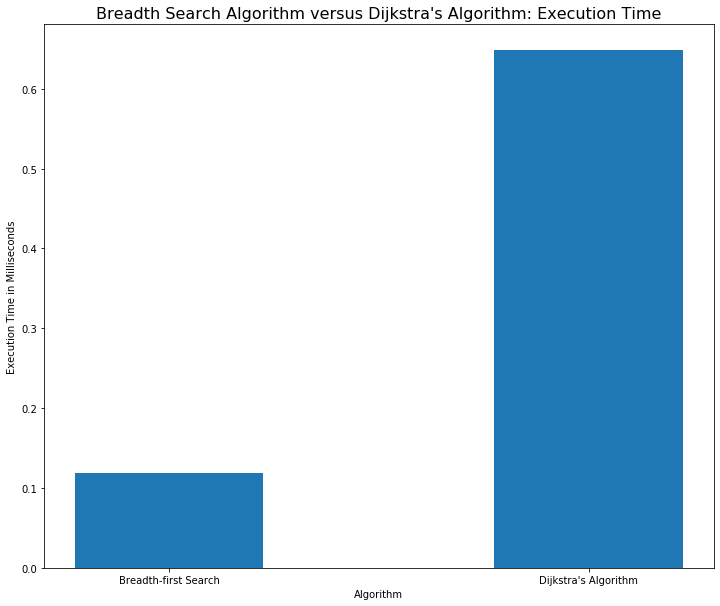

In [48]:
# Plot of execution time
plt.figure(figsize=(12,10))
plt.bar(algorithms_df['Algorithm'], algorithms_df['Execution Time'], width=0.45)
plt.xlabel('Algorithm')
plt.ylabel('Execution Time in Milliseconds')
plt.title('Breadth Search Algorithm versus Dijkstra\'s Algorithm: Execution Time', fontsize=16)
plt.show();

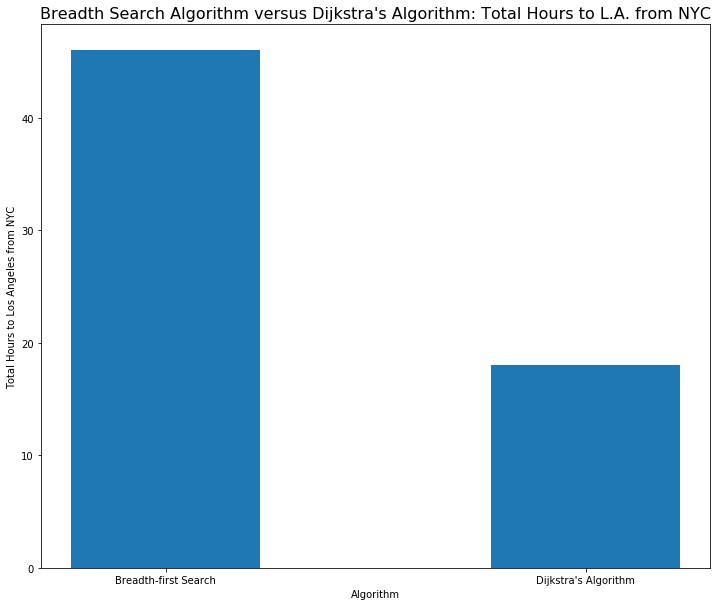

In [47]:
# Plot of time to LA from NYC
plt.figure(figsize=(12,10))
plt.bar(algorithms_df['Algorithm'], algorithms_df['Time to L.A.'], width=0.45)
plt.xlabel('Algorithm')
plt.ylabel('Total Hours to Los Angeles from NYC')
plt.title('Breadth Search Algorithm versus Dijkstra\'s Algorithm: Total Hours to L.A. from NYC', fontsize=16)
plt.show();

### Conclusion:
In this exercise Dijkstra's algorithm was examined by finding the fastest way from NYC to Los Angeles through a weighted connections graph showing the hours (or weights) it would take going from city to city. Basically Dijsktra's algorithm works by finding the "cheapest" node (city), or the node that we can get to in the least amount of time, update the the costs (hours) of the neighbors of the node (city), and repeat until this is done for every node (city) in the graph [1]. Then the final path is calculated, where the fastest path is found through the lowest costs (hours) of neighboring nodes (cities). The algorithm in this exercise was compared with the breadth-first search algorithm, which instead of finding the fastest path, it finds the shortest. The breadth-first search algorithm will find the shortest path between two nodes that are connected to other nodes by the unweighted edges. The algorithm will first determine if there is a path leading from one node to the other, and it will then find the shortest path by searching the entire network of connections finding the shortest path connections between the two nodes. Thus, in this exercise, the path and the total hours from start to destination was evaluated.

In terms of Big O notation, at its worst case, assuming that the graph is using a self-balancing binary search tree, Dijsktra's algorithm is written as **O(|E|+|V|)log|V|)** [2]. |V| is for the number of vertices, and |E| is for the number of edges, or connections. When an entire network is searched, each edge is followed, and so the run time is at the least, O(number of edges). There is also a queue for every node that is to be searched, and adding one node to the queue takes O(1) constant time. Doing this for every node will take (O number of nodes) total. log |V| is the time that it takes to go through neighboring vertices. Therefore, total run time is **O(|E|+|V|)log|V|)** in the case of a self-balancing binary search tree. Breadth first search has similar notation, yet it is written as **O(V+E)**, as it does not account for the weighted edges. Therefore, breadth-first search runs faster. It is also important to note that Dijkstra's algorithm cannot work with weighted edges that are negative. In this case, the Bellman-Ford algorithm can be used. 

The results of this exercise showed that while execution times were significantly different, it was a better trade-off, as Dijskstra's algorithm did its job by finding the fastest path to get from NYC to Los Angeles where the total time calculated  was 18 hours, and the total time calculated for breadth-first search was 46. In this case results showed that it is best to go through a network of weighted edges using Dijkstra's algorithm at the cost of a longer execution time, than finding the shortest path through a network of weighted edges using breadth-first search with a shorter execution time. 

It is therefore recommended that the Dijkstra's algorithm is used for cases where a weighted connections graph is necessary for a fastest path problem. One example is in mapping data transfer between distributed systems. It is thus useful to the data engineer to know how the algorithm works and how it is implemented, as it is an effective means to solve complex problems involving weighted edges, where other search algorithms cannot be easily applied. 

### References:
[1] Bhargava, A. Y.(2016.) Grokking Algorithms: An Illustrated Guide for Programmers and Other Curious People. Shelter Island, N.Y.: Manning.

[2] https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm. Accessed: November 9, 2019.

[3] Kleppmann, M. (2017.) Designing Data-Intensive Applications: The Big Ideas behind Reliable, Scalable, and Maintainable Systems. Sebastopol, Calif.: O’Reilly.